Processing sound categories: 100%|██████████| 12/12 [08:35<00:00, 42.99s/it]


X_data shape: (29847, 128, 52)
y_data shape: (29847,)
First 10 labels in y_data: ['cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough'
 'cough']


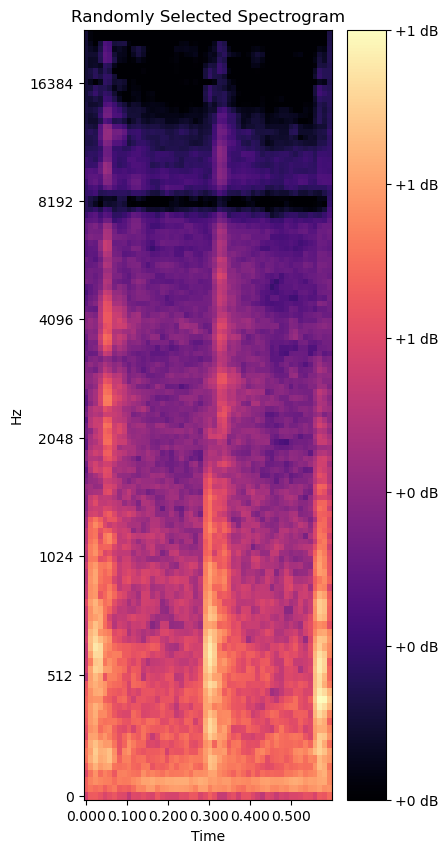

Selected y label: running_outdoor


In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm

# 루트 디렉토리 경로
root_directory = '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람'

# 처리할 소리 데이터와 라벨
sound_labels = {
    '1.생리현상/1.기침': 'cough',
    '1.생리현상/2.트림': 'burp',
    '1.생리현상/3.방귀': 'fart',
    '1.생리현상/4.재채기': 'sneeze',
    '2.신체를 이용한 인위적 소리/1.박수': 'clap',
    '2.신체를 이용한 인위적 소리/3.휘파람': 'whistle',
    '3.감정/1.웃음': 'laughter',
    '3.감정/2.울음': 'crying',
    '3.감정/3.비명': 'scream',
    '4.이동감지/1.실외에서 걸으면서 이동하는 소리': 'walking_outdoor',
    '4.이동감지/2.밟는소리': 'footstep',
    '4.이동감지/3.실외에서 뛰면서 이동하는 소리': 'running_outdoor',
}

# 윈도우 크기 및 기타 설정
window_duration = 0.6  # 초
hop_length = 512  # 기본 hop length
window_size = None
minimum_distance = None
sr = None  # 샘플링 레이트

# 데이터 저장용 리스트 초기화
X_data = []
y_data = []

def process_audio_files(directory, label):
    global window_size, sr, minimum_distance
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))

    for file_path in tqdm(file_paths, desc=f'Processing {label} files'):
        y, sr = librosa.load(file_path, sr=None)
        start_time = 8
        start_sample = int(start_time * sr)
        y_trimmed = y[start_sample:]
        y_trimmed_db = librosa.amplitude_to_db(np.abs(y_trimmed), ref=np.max)
        threshold_db = -20
        indices = np.where(y_trimmed_db > threshold_db)[0]

        if window_size is None:
            window_size = int(window_duration * sr)
            minimum_distance = int(0.6 * sr)
        
        last_index = -minimum_distance

        for i, idx in enumerate(indices):
            if idx - last_index >= minimum_distance:
                start_idx = max(0, idx - window_size // 2)
                end_idx = min(len(y_trimmed), idx + window_size // 2)
                y_window = y_trimmed[start_idx:end_idx]
                S_window = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=128, hop_length=hop_length)
                S_window_dB = librosa.power_to_db(S_window, ref=np.max)
                S_window_dB_normalized = (S_window_dB - np.min(S_window_dB)) / (np.max(S_window_dB) - np.min(S_window_dB))

                # 스펙트로그램의 크기를 확인하고 패딩 적용
                target_width = (window_size // hop_length) + 1
                if S_window_dB_normalized.shape[1] < target_width:
                    padding = target_width - S_window_dB_normalized.shape[1]
                    S_window_dB_normalized = np.pad(S_window_dB_normalized, ((0, 0), (0, padding)), mode='constant')
                
                X_data.append(S_window_dB_normalized)
                y_data.append(label)
                last_index = idx

# 모든 소리 데이터를 처리
for subdir, label in tqdm(sound_labels.items(), desc='Processing sound categories'):
    directory = os.path.join(root_directory, subdir)
    process_audio_files(directory, label)

# numpy 배열로 변환
X_data = np.array(X_data)
y_data = np.array(y_data)

# 데이터 저장
np.save('X_train.npy', X_data)
np.save('y_train.npy', y_data)

# 데이터 크기 확인
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

# y_data의 처음 10개 값 출력
print('First 10 labels in y_data:', y_data[:10])

# 무작위로 1개의 스펙트로그램 선택 및 시각화
import random
random_idx = random.choice(range(X_data.shape[0]))

# 시각화
fig, ax = plt.subplots(figsize=(4, 10))  # 세로로 긴 형태로 설정
img = librosa.display.specshow(X_data[random_idx], sr=sr, x_axis='time', y_axis='mel', ax=ax)
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Randomly Selected Spectrogram')

# 이미지를 저장합니다 (선택 사항)
plt.savefig('random_spectrogram_long.png', bbox_inches='tight', pad_inches=0)
plt.show()

# 해당 y 라벨 프린트
print('Selected y label:', y_data[random_idx])


X_data shape: (29847, 128, 52)
y_data shape: (29847,)
Selected y label: walking_outdoor


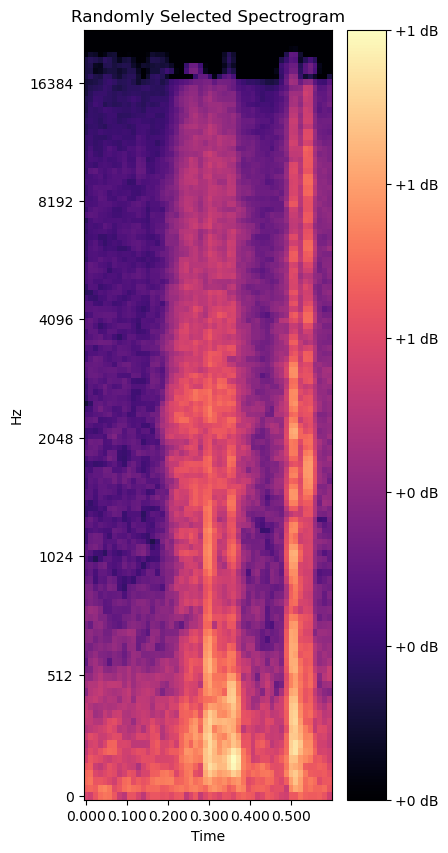

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import random

# 데이터 로드
X_data_padded = np.load('X_train.npy')
y_data = np.load('y_train.npy')

# 데이터 크기 확인
print(f'X_data shape: {X_data_padded.shape}')
print(f'y_data shape: {y_data.shape}')

# 무작위로 하나의 인덱스 선택
random_idx = random.randint(0, X_data_padded.shape[0] - 1)

# 선택된 스펙트로그램과 라벨 가져오기
selected_X = X_data_padded[random_idx]
selected_y = y_data[random_idx]

# 선택된 스펙트로그램 이미지로 시각화
fig, ax = plt.subplots(figsize=(4, 10))  # 세로로 긴 형태로 설정
img = librosa.display.specshow(selected_X, sr=sr, x_axis='time', y_axis='mel', ax=ax)
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Randomly Selected Spectrogram')

# 이미지를 저장합니다 (선택 사항)
print('Selected y label:', selected_y)

plt.savefig('random_spectrogram_long.png', bbox_inches='tight', pad_inches=0)
plt.show()

# 해당 y 라벨 프린트


In [102]:
independent = np.load('X_train.npy')
independent = independent.reshape(independent.shape[0], independent.shape[1], independent.shape[2], 1)

independent.shape

(29847, 128, 52, 1)

In [101]:
dependent = np.load('y_train.npy')
dependent.shape

(29847,)